In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, fbeta_score, accuracy_score, recall_score, confusion_matrix
from sklearn.dummy import DummyClassifier
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
import mlflow
import mlflow.sklearn
import time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# Charger les données
file_path = 'C:/Users/Heliosaun/Desktop/Projet7/FINAL/data/final_dataset.csv'
df = pd.read_csv(file_path)

In [3]:
df.head()

,index,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
0,0,100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
4,4,100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Remplacer les valeurs infinies par NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Suppression des lignes où TARGET est NaN
df = df.dropna(subset=['TARGET'])

# Sélection des features pour la modélisation (toutes sauf TARGET)
features = df.columns.drop('TARGET', 'SK_ID_CURR')
X = df[features]
y = df['TARGET']

# Gestion des valeurs manquantes par imputation de la médiane
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Normalisation des features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Division en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Application de SMOTE pour l'ensemble d'entraînement
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

2024/01/08 12:42:37 INFO mlflow.tracking.fluent: Experiment with name 'baseline_dummy_classifier' does not exist. Creating a new experiment.


Résultats du DummyClassifier :
          Metric     Value
0            AUC  0.500000
1       F2 Score  0.000000
2       Accuracy  0.918360
3         Recall  0.000000
4  Training Time  0.007936


C:\ProgramData\anaconda3\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


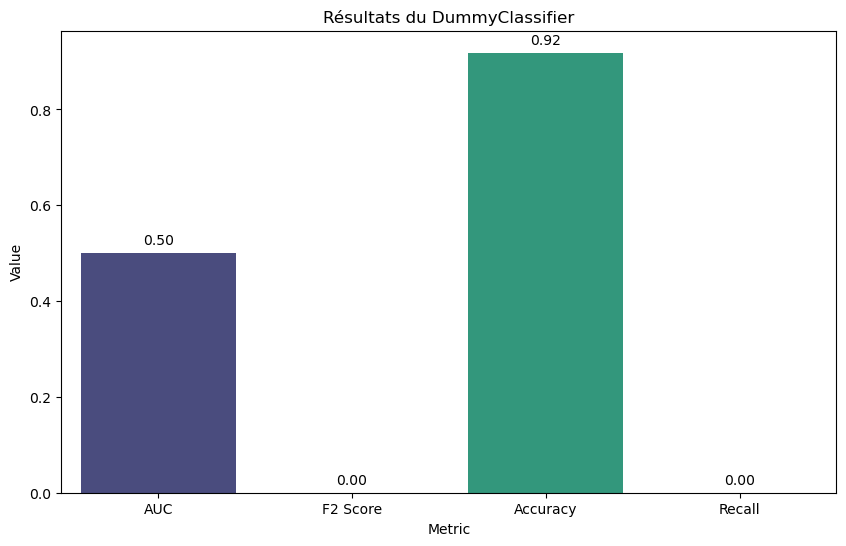

In [6]:
# Configuration de MLflow pour le DummyClassifier
mlflow.set_experiment('baseline_dummy_classifier')

with mlflow.start_run(run_name='Dummy'):
    # Entraînement du DummyClassifier
    dummy_start_time = time.time()
    dummy_model = DummyClassifier(strategy='most_frequent', random_state=42)
    dummy_model.fit(X_train, y_train)  # Note: X_train et y_train sans SMOTE
    dummy_elapsed_time = time.time() - dummy_start_time

    # Prédiction sur l'ensemble de test
    dummy_y_pred = dummy_model.predict(X_test)
    dummy_y_pred_proba = dummy_model.predict_proba(X_test)[:, 1]

    # Calcul des métriques pour DummyClassifier
    dummy_auc_score = roc_auc_score(y_test, dummy_y_pred_proba)
    dummy_f2_score = fbeta_score(y_test, dummy_y_pred, beta=2)
    dummy_accuracy = accuracy_score(y_test, dummy_y_pred)
    dummy_recall = recall_score(y_test, dummy_y_pred)
    
    # Enregistrement des métriques dans MLflow
    mlflow.log_metric('AUC', dummy_auc_score)
    mlflow.log_metric('F2 Score', dummy_f2_score)
    mlflow.log_metric('Accuracy', dummy_accuracy)
    mlflow.log_metric('Recall', dummy_recall)
    mlflow.log_metric('Training Time', dummy_elapsed_time)

    # Enregistrement du modèle
    mlflow.sklearn.log_model(dummy_model, 'dummy_model')

# Affichage des résultats pour DummyClassifier
dummy_metrics = ['AUC', 'F2 Score', 'Accuracy', 'Recall', 'Training Time']
dummy_values = [dummy_auc_score, dummy_f2_score, dummy_accuracy, dummy_recall, dummy_elapsed_time]
dummy_metrics_table = pd.DataFrame({'Metric': dummy_metrics, 'Value': dummy_values})

print("Résultats du DummyClassifier :")
print(dummy_metrics_table)

# Métriques pour le graphique, sans le temps d'entraînement
dummy_metrics_graph = ['AUC', 'F2 Score', 'Accuracy', 'Recall']
dummy_values_graph = [dummy_auc_score, dummy_f2_score, dummy_accuracy, dummy_recall]
dummy_metrics_table_graph = pd.DataFrame({'Metric': dummy_metrics_graph, 'Value': dummy_values_graph})

# Création du graphique avec Seaborn sans le temps d'entraînement
plt.figure(figsize=(10, 6))
dummy_bar_plot = sns.barplot(x='Metric', y='Value', data=dummy_metrics_table_graph, palette='viridis')
for p in dummy_bar_plot.patches:
    dummy_bar_plot.annotate(format(p.get_height(), '.2f'), 
                            (p.get_x() + p.get_width() / 2., p.get_height()), 
                            ha = 'center', va = 'center', 
                            xytext = (0, 9), 
                            textcoords = 'offset points')
plt.title('Résultats du DummyClassifier')
plt.show()

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Résultats de la Régression Logistique :
          Metric      Value
0            AUC   0.755412
1       F2 Score   0.425254
2       Accuracy   0.722464
3         Recall   0.655845
4  Training Time  18.446264


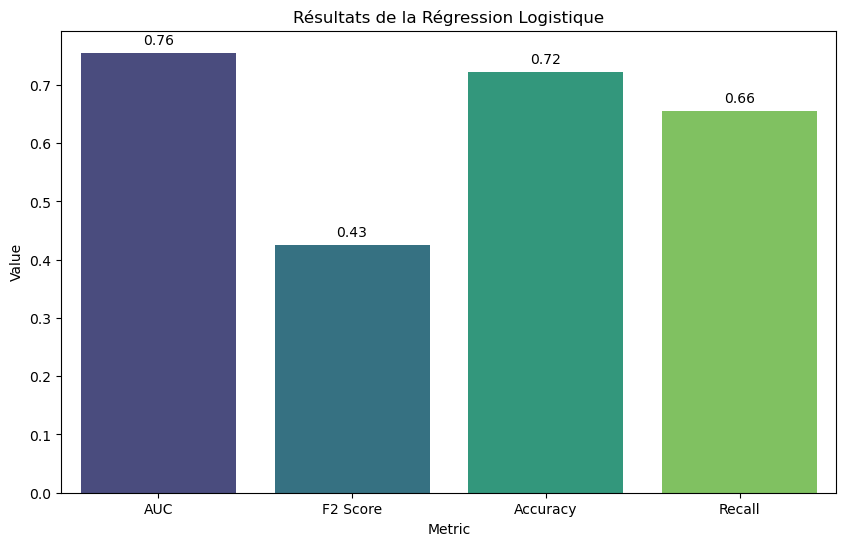

In [14]:
# Configuration de MLflow pôur la Régréssion Logistique
mlflow.set_experiment('baseline_regression_logistique')

with mlflow.start_run():
    # Entraînement du modèle
    start_time = time.time()
    model = LogisticRegression()
    model.fit(X_train_resampled, y_train_resampled)
    logreg_elapsed_time = time.time() - start_time

    # Prédiction sur l'ensemble de test
    logreg_y_pred = model.predict(X_test)
    logreg_y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calcul des métriques
    logreg_auc_score = roc_auc_score(y_test, logreg_y_pred_proba)
    logreg_f2_score = fbeta_score(y_test, logreg_y_pred, beta=2)
    logreg_accuracy = accuracy_score(y_test, logreg_y_pred)
    logreg_recall = recall_score(y_test, logreg_y_pred)
    
    # Enregistrement des métriques dans MLflow
    mlflow.log_metric('AUC', logreg_auc_score)
    mlflow.log_metric('F2 Score', logreg_f2_score)
    mlflow.log_metric('Accuracy', logreg_accuracy)
    mlflow.log_metric('Recall', logreg_recall)
    mlflow.log_metric('Training Time', logreg_elapsed_time)

    # Enregistrement du modèle
    mlflow.sklearn.log_model(model, 'model')

# Métriques pour l'affichage, y compris le temps d'entraînement
logreg_metrics_all = ['AUC', 'F2 Score', 'Accuracy', 'Recall', 'Training Time']
logreg_values_all = [logreg_auc_score, logreg_f2_score, logreg_accuracy, logreg_recall, logreg_elapsed_time]
logreg_metrics_table_all = pd.DataFrame({'Metric': logreg_metrics_all, 'Value': logreg_values_all})

print("Résultats de la Régression Logistique :")
print(logreg_metrics_table_all)

# Métriques pour le graphique, sans le temps d'entraînement
logreg_metrics_graph = ['AUC', 'F2 Score', 'Accuracy', 'Recall']
logreg_values_graph = [logreg_auc_score, logreg_f2_score, logreg_accuracy, logreg_recall]
logreg_metrics_table_graph = pd.DataFrame({'Metric': logreg_metrics_graph, 'Value': logreg_values_graph})

# Création du graphique pour la Régression Logistique
plt.figure(figsize=(10, 6))
logreg_bar_plot = sns.barplot(x='Metric', y='Value', data=logreg_metrics_table_graph, palette='viridis')
for p in logreg_bar_plot.patches:
    logreg_bar_plot.annotate(format(p.get_height(), '.2f'), 
                             (p.get_x() + p.get_width() / 2., p.get_height()), 
                             ha = 'center', va = 'center', 
                             xytext = (0, 9), 
                             textcoords = 'offset points')
plt.title('Résultats de la Régression Logistique')
plt.show()

Résultats du XGBoost :
          Metric       Value
0            AUC    0.766421
1       F2 Score    0.072279
2       Accuracy    0.917238
3         Recall    0.059749
4  Training Time  410.766073


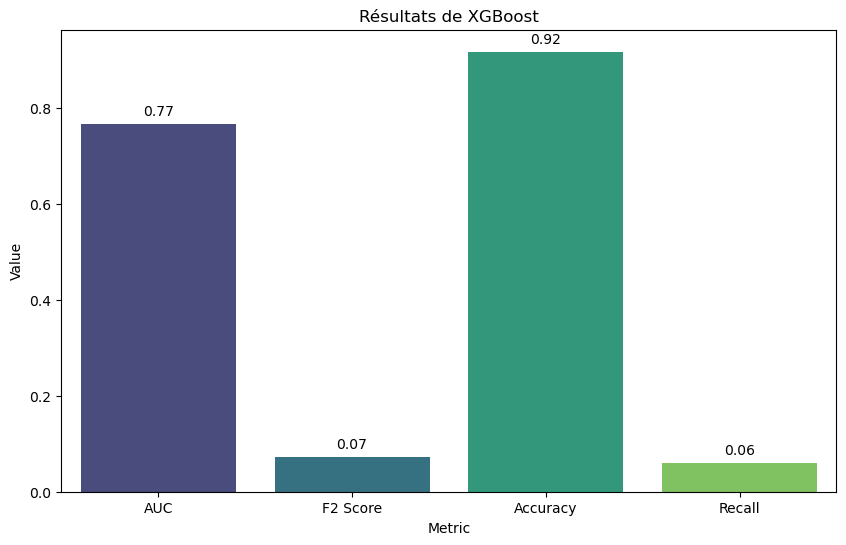

In [8]:
# Configuration de MLflow pour XGBoost
mlflow.set_experiment('baseline_xgboost')

with mlflow.start_run(run_name='XGBoost'):
    # Entraînement du modèle XGBoost
    xgb_start_time = time.time()
    xgb_model = xgb.XGBClassifier()
    xgb_model.fit(X_train_resampled, y_train_resampled)
    xgb_elapsed_time = time.time() - xgb_start_time

    # Prédiction sur l'ensemble de test
    xgb_y_pred = xgb_model.predict(X_test)
    xgb_y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

    # Calcul des métriques pour XGBoost
    xgb_auc_score = roc_auc_score(y_test, xgb_y_pred_proba)
    xgb_f2_score = fbeta_score(y_test, xgb_y_pred, beta=2)
    xgb_accuracy = accuracy_score(y_test, xgb_y_pred)
    xgb_recall = recall_score(y_test, xgb_y_pred)
    
    # Enregistrement des métriques dans MLflow
    mlflow.log_metric('AUC', xgb_auc_score)
    mlflow.log_metric('F2 Score', xgb_f2_score)
    mlflow.log_metric('Accuracy', xgb_accuracy)
    mlflow.log_metric('Recall', xgb_recall)
    mlflow.log_metric('Training Time', xgb_elapsed_time)

    # Enregistrement du modèle
    mlflow.sklearn.log_model(xgb_model, 'xgb_model')

# Affichage des résultats pour XGBoost
xgb_metrics = ['AUC', 'F2 Score', 'Accuracy', 'Recall', 'Training Time']
xgb_values = [xgb_auc_score, xgb_f2_score, xgb_accuracy, xgb_recall, xgb_elapsed_time]
xgb_metrics_table = pd.DataFrame({'Metric': xgb_metrics, 'Value': xgb_values})

print("Résultats du XGBoost :")
print(xgb_metrics_table)

# Métriques pour le graphique, sans le temps d'entraînement
xgb_metrics_graph = ['AUC', 'F2 Score', 'Accuracy', 'Recall']
xgb_values_graph = [xgb_auc_score, xgb_f2_score, xgb_accuracy, xgb_recall]
xgb_metrics_table_graph = pd.DataFrame({'Metric': xgb_metrics_graph, 'Value': xgb_values_graph})

# Création du graphique pour la Régression Logistique
plt.figure(figsize=(10, 6))
xgb_bar_plot = sns.barplot(x='Metric', y='Value', data=xgb_metrics_table_graph, palette='viridis')
for p in xgb_bar_plot.patches:
    xgb_bar_plot.annotate(format(p.get_height(), '.2f'), 
                             (p.get_x() + p.get_width() / 2., p.get_height()), 
                             ha = 'center', va = 'center', 
                             xytext = (0, 9), 
                             textcoords = 'offset points')
plt.title('Résultats de XGBoost')
plt.show()

[LightGBM] [Info] Number of positive: 19804, number of negative: 226201
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.621558 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 100236
[LightGBM] [Info] Number of data points in the train set: 246005, number of used features: 729
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080502 -> initscore=-2.435540
[LightGBM] [Info] Start training from score -2.435540
Résultats du LGBM :
          Metric      Value
0            AUC   0.777908
1       F2 Score   0.039992
2       Accuracy   0.918864
3         Recall   0.032464
4  Training Time  20.375206


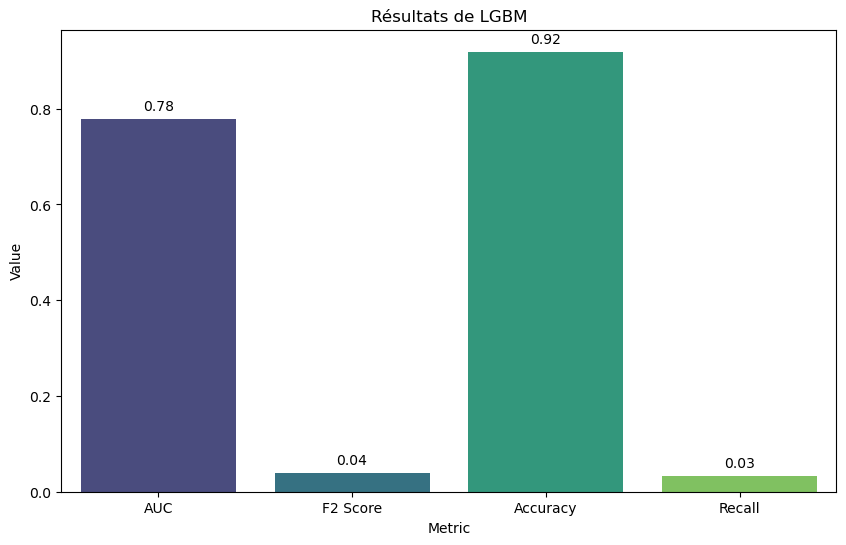

In [19]:
# Configuration de MLflow pour LightGBM
mlflow.set_experiment('baseline_lightgbm')

with mlflow.start_run(run_name='LightGBM'):
    # Entraînement du modèle LightGBM
    lgb_start_time = time.time()
    lgb_model = lgb.LGBMClassifier()
    lgb_model.fit(X_train, y_train)
    lgb_elapsed_time = time.time() - lgb_start_time

    # Prédiction sur l'ensemble de test
    lgb_y_pred = lgb_model.predict(X_test)
    lgb_y_pred_proba = lgb_model.predict_proba(X_test)[:, 1]

    # Calcul des métriques pour LightGBM
    lgb_auc_score = roc_auc_score(y_test, lgb_y_pred_proba)
    lgb_f2_score = fbeta_score(y_test, lgb_y_pred, beta=2)
    lgb_accuracy = accuracy_score(y_test, lgb_y_pred)
    lgb_recall = recall_score(y_test, lgb_y_pred)
    
    # Enregistrement des métriques dans MLflow
    mlflow.log_metric('AUC', lgb_auc_score)
    mlflow.log_metric('F2 Score', lgb_f2_score)
    mlflow.log_metric('Accuracy', lgb_accuracy)
    mlflow.log_metric('Recall', lgb_recall)
    mlflow.log_metric('Training Time', lgb_elapsed_time)

    # Enregistrement du modèle
    mlflow.sklearn.log_model(lgb_model, 'lgb_model')

# Affichage des résultats pour LightGBM
lgb_metrics = ['AUC', 'F2 Score', 'Accuracy', 'Recall', 'Training Time']
lgb_values = [lgb_auc_score, lgb_f2_score, lgb_accuracy, lgb_recall, lgb_elapsed_time]
lgb_metrics_table = pd.DataFrame({'Metric': lgb_metrics, 'Value': lgb_values})

print("Résultats du LGBM :")
print(lgb_metrics_table)

# Métriques pour le graphique, sans le temps d'entraînement
lgb_metrics_graph = ['AUC', 'F2 Score', 'Accuracy', 'Recall']
lgb_values_graph = [lgb_auc_score, lgb_f2_score, lgb_accuracy, lgb_recall]
lgb_metrics_table_graph = pd.DataFrame({'Metric': lgb_metrics_graph, 'Value': lgb_values_graph})

# Création du graphique pour LightGBM
plt.figure(figsize=(10, 6))
lgb_bar_plot = sns.barplot(x='Metric', y='Value', data=lgb_metrics_table_graph, palette='viridis')
for p in lgb_bar_plot.patches:
    lgb_bar_plot.annotate(format(p.get_height(), '.2f'), 
                             (p.get_x() + p.get_width() / 2., p.get_height()), 
                             ha = 'center', va = 'center', 
                             xytext = (0, 9), 
                             textcoords = 'offset points')
plt.title('Résultats de LGBM')
plt.show()

Résultats du CatBoost :
          Metric       Value
0            AUC    0.777694
1       F2 Score    0.064560
2       Accuracy    0.918604
3         Recall    0.052977
4  Training Time  311.110615


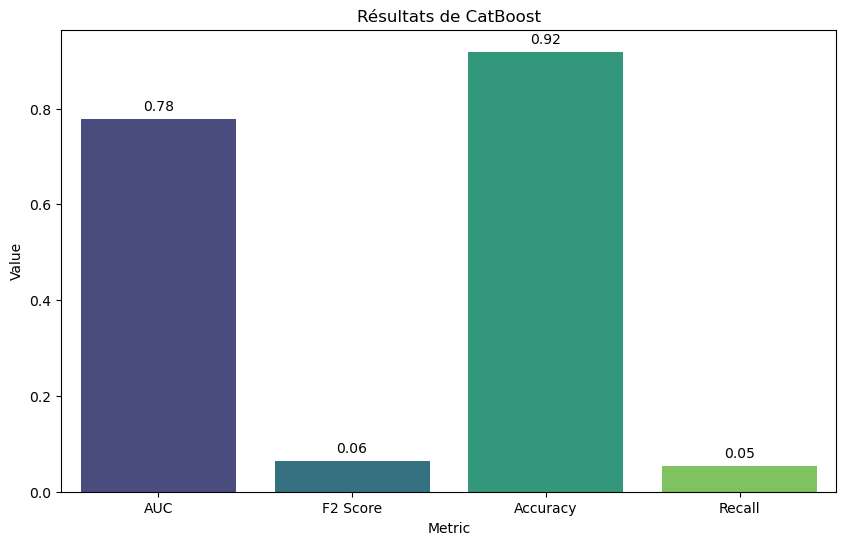

In [10]:
# Configuration de MLflow pour CatBoost
mlflow.set_experiment('baseline_catboost')

with mlflow.start_run(run_name='CatBoost'):
    # Entraînement du modèle CatBoost
    cat_start_time = time.time()
    cat_model = CatBoostClassifier(verbose=0)
    cat_model.fit(X_train_resampled, y_train_resampled)
    cat_elapsed_time = time.time() - cat_start_time

    # Prédiction sur l'ensemble de test
    cat_y_pred = cat_model.predict(X_test)
    cat_y_pred_proba = cat_model.predict_proba(X_test)[:, 1]

    # Calcul des métriques pour CatBoost
    cat_auc_score = roc_auc_score(y_test, cat_y_pred_proba)
    cat_f2_score = fbeta_score(y_test, cat_y_pred, beta=2)
    cat_accuracy = accuracy_score(y_test, cat_y_pred)
    cat_recall = recall_score(y_test, cat_y_pred)
    
    # Enregistrement des métriques dans MLflow
    mlflow.log_metric('AUC', cat_auc_score)
    mlflow.log_metric('F2 Score', cat_f2_score)
    mlflow.log_metric('Accuracy', cat_accuracy)
    mlflow.log_metric('Recall', cat_recall)
    mlflow.log_metric('Training Time', cat_elapsed_time)

    # Enregistrement du modèle
    mlflow.sklearn.log_model(cat_model, 'cat_model')
    
# Affichage des résultats pour CatBoost
cat_metrics = ['AUC', 'F2 Score', 'Accuracy', 'Recall', 'Training Time']
cat_values = [cat_auc_score, cat_f2_score, cat_accuracy, cat_recall, cat_elapsed_time]
cat_metrics_table = pd.DataFrame({'Metric': cat_metrics, 'Value': cat_values})

print("Résultats du CatBoost :")
print(cat_metrics_table)

# Métriques pour le graphique, sans le temps d'entraînement
cat_metrics_graph = ['AUC', 'F2 Score', 'Accuracy', 'Recall']
cat_values_graph = [cat_auc_score, cat_f2_score, cat_accuracy, cat_recall]
cat_metrics_table_graph = pd.DataFrame({'Metric': cat_metrics_graph, 'Value': cat_values_graph})

# Création du graphique pour CatBoost
plt.figure(figsize=(10, 6))
cat_bar_plot = sns.barplot(x='Metric', y='Value', data=cat_metrics_table_graph, palette='viridis')
for p in cat_bar_plot.patches:
    cat_bar_plot.annotate(format(p.get_height(), '.2f'), 
                             (p.get_x() + p.get_width() / 2., p.get_height()), 
                             ha = 'center', va = 'center', 
                             xytext = (0, 9), 
                             textcoords = 'offset points')
plt.title('Résultats de CatBoost')
plt.show()

In [15]:
# Création des tableaux pour chaque modèle
models = ["Dummy", "LogReg", "XGBoost", "LightGBM", "CatBoost"]
auc_scores = [dummy_auc_score, logreg_auc_score, xgb_auc_score, lgb_auc_score, cat_auc_score]
f2_scores = [dummy_f2_score, logreg_f2_score, xgb_f2_score, lgb_f2_score, cat_f2_score]
accuracies = [dummy_accuracy, logreg_accuracy, xgb_accuracy, lgb_accuracy, cat_accuracy]
recalls = [dummy_recall, logreg_recall, xgb_recall, lgb_recall, cat_recall]
training_times = [dummy_elapsed_time, logreg_elapsed_time, xgb_elapsed_time, lgb_elapsed_time, cat_elapsed_time]

# Création du tableau récapitulatif
results_table = pd.DataFrame({
    "Model": models,
    "AUC": auc_scores,
    "F2 Score": f2_scores,
    "Accuracy": accuracies,
    "Recall": recalls,
    "Training Time": training_times
})

print(results_table)

      Model       AUC  F2 Score  Accuracy    Recall  Training Time
0     Dummy  0.500000  0.000000  0.918360  0.000000       0.007936
1    LogReg  0.755412  0.425254  0.722464  0.655845      18.446264
2   XGBoost  0.766421  0.072279  0.917238  0.059749     410.766073
3  LightGBM  0.766118  0.026373  0.918555  0.021310      39.771882
4  CatBoost  0.777694  0.064560  0.918604  0.052977     311.110615


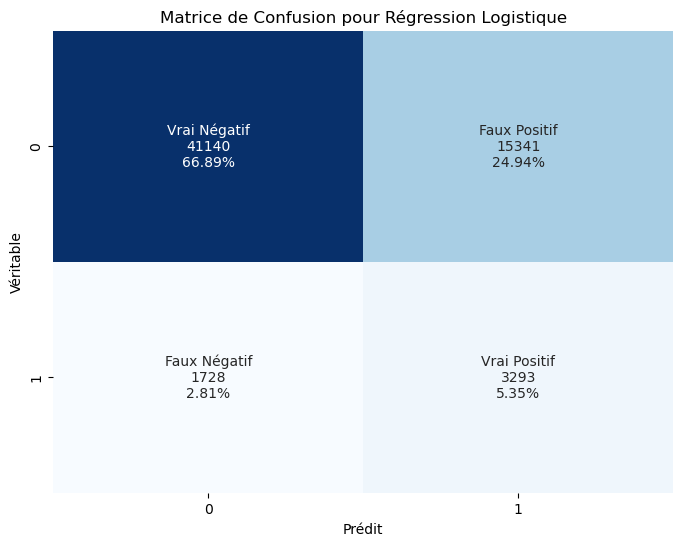

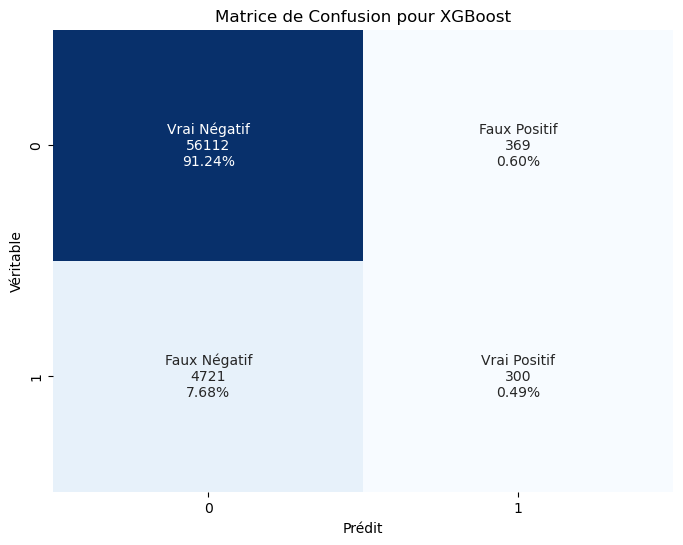

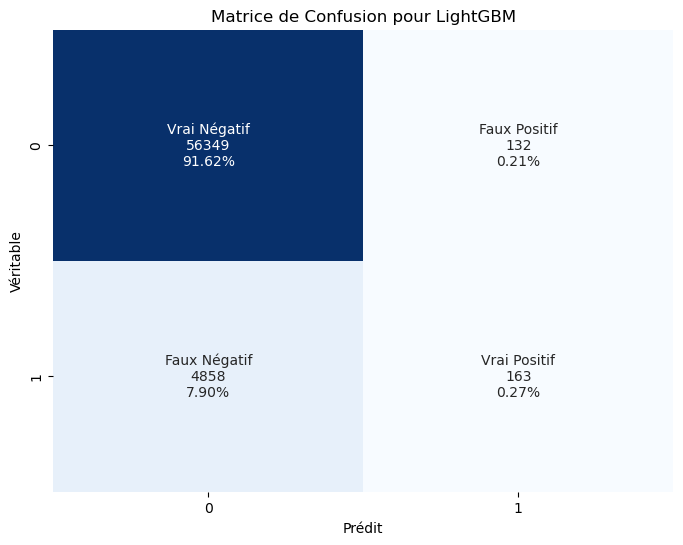

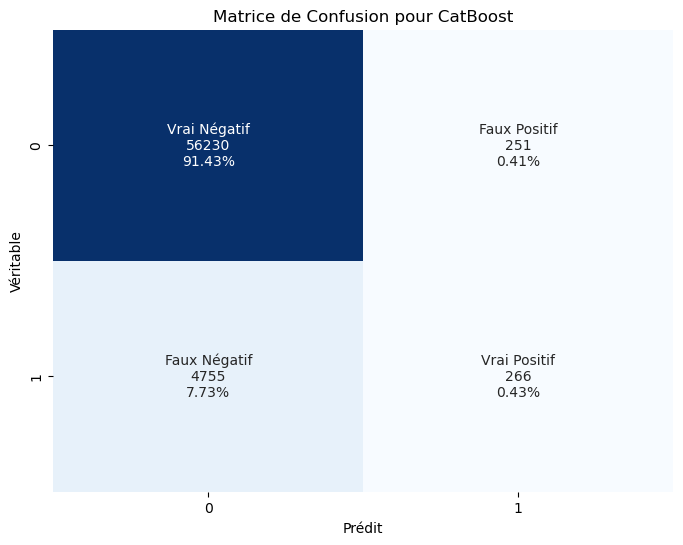

In [25]:
def plot_confusion_matrix(y_true, y_pred, model_name):
    conf_mat = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8, 6))

    # Labels pour chaque case
    group_names = ['Vrai Négatif', 'Faux Positif', 'Faux Négatif', 'Vrai Positif']
    group_counts = [f"{value}" for value in conf_mat.flatten()]
    group_percentages = [f"{value:.2%}" for value in conf_mat.flatten()/np.sum(conf_mat)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]

    # Redimensionnement des labels pour correspondre à la matrice
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(conf_mat, annot=labels, fmt='', cmap='Blues', cbar=False)
    plt.ylabel('Véritable')
    plt.xlabel('Prédit')
    plt.title(f'Matrice de Confusion pour {model_name}')
    plt.show()

# Exemples d'appel de la fonction pour chaque modèle
plot_confusion_matrix(y_test, logreg_y_pred, 'Régression Logistique')
plot_confusion_matrix(y_test, xgb_y_pred, 'XGBoost')
plot_confusion_matrix(y_test, lgb_y_pred, 'LightGBM')
plot_confusion_matrix(y_test, cat_y_pred, 'CatBoost')

In [ ]:
from sklearn.feature_selection import RFECV
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, fbeta_score, accuracy_score, recall_score
import mlflow
import mlflow.sklearn
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Configuration de la validation croisée stratifiée
cv = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)

# Configuration de MLflow pour LightGBM
mlflow.set_experiment('baseline_lightgbm')

with mlflow.start_run(run_name='LightGBM_RFECV'):
    # Application de RFECV
    selector = RFECV(estimator=LGBMClassifier(), step=1, cv=cv, scoring='roc_auc')
    selector.fit(X_train, y_train)

    # Affichage du nombre optimal de features
    print("Nombre optimal de features : %d" % selector.n_features_)

    # Filtrer les données pour n'utiliser que les features sélectionnées
    X_train_selected = selector.transform(X_train)
    X_test_selected = selector.transform(X_test)

    # Entraînement du modèle LightGBM avec les features sélectionnées
    lgb_start_time = time.time()
    lgb_model = LGBMClassifier()
    lgb_model.fit(X_train_selected, y_train)
    lgb_elapsed_time = time.time() - lgb_start_time

    # Prédiction sur l'ensemble de test
    lgb_y_pred = lgb_model.predict(X_test_selected)
    lgb_y_pred_proba = lgb_model.predict_proba(X_test_selected)[:, 1]

    # Calcul des métriques pour LightGBM
    lgb_auc_score = roc_auc_score(y_test, lgb_y_pred_proba)
    lgb_f2_score = fbeta_score(y_test, lgb_y_pred, beta=2)
    lgb_accuracy = accuracy_score(y_test, lgb_y_pred)
    lgb_recall = recall_score(y_test, lgb_y_pred)
    
    # Enregistrement des métriques dans MLflow
    mlflow.log_metric('AUC', lgb_auc_score)
    mlflow.log_metric('F2 Score', lgb_f2_score)
    mlflow.log_metric('Accuracy', lgb_accuracy)
    mlflow.log_metric('Recall', lgb_recall)
    mlflow.log_metric('Training Time', lgb_elapsed_time)
    mlflow.log_metric('Optimal Features', selector.n_features_)

    # Enregistrement du modèle
    mlflow.sklearn.log_model(lgb_model, 'lgb_model_rfecv')

# Affichage des résultats pour LightGBM avec RFECV
lgb_metrics = ['AUC', 'F2 Score', 'Accuracy', 'Recall', 'Training Time', 'Optimal Features']
lgb_values = [lgb_auc_score, lgb_f2_score, lgb_accuracy, lgb_recall, lgb_elapsed_time, selector.n_features_]
lgb_metrics_table = pd.DataFrame({'Metric': lgb_metrics, 'Value': lgb_values})

print("Résultats du LGBM avec RFECV :")
print(lgb_metrics_table)

# Création du graphique pour LightGBM avec RFECV
plt.figure(figsize=(10, 6))
lgb_bar_plot = sns.barplot(x='Metric', y='Value', data=lgb_metrics_table.drop(5), palette='viridis') # Exclure 'Optimal Features' du graphique
for p in lgb_bar_plot.patches:
    lgb_bar_plot.annotate(format(p.get_height(), '.2f'), 
                             (p.get_x() + p.get_width() / 2., p.get_height()), 
                             ha = 'center', va = 'center', 
                             xytext = (0, 9), 
                             textcoords = 'offset points')
plt.title('Résultats de LGBM avec RFECV')
plt.show()